# Preliminaries

In [1]:
BANDS = ['Y106', 'J129', 'H158', 'F184', 'K213']
KERNELS = ['Chol', 'Iter']
SUITES = {
    'Common': ['benchmark', 'airyobsc', 'airyunobsc', 'gauss_0.8x', 'gauss_1.2x',
               'psfcirc', 'psfnorm', 'amppen', 'flatpen'],
    'Chol': ['kappac_3x', 'kappac_9x', 'inpad=1.00', 'inpad=0.76'],
    'Iter': ['rtol=4.5e-3', 'rtol=5.0e-4', 'inpad=0.75', 'inpad=0.45'],
}

In [2]:
from pathlib import Path

SCRATCH = Path('/fs/scratch/PAS2733/kailicao')
PROJECT = Path('/users/PAS2055/kailicao/pyimcom_dev')
INCONFIG = Path('/users/PAS2055/kailicao/pyimcom_dev/pyimcom/configs/production_configs_spring2024')
OUTCONFIG = Path('/users/PAS2055/kailicao/pyimcom_dev/paper4_configs')
SCRIPTS = Path('/users/PAS2055/kailicao/pyimcom_dev/paper4_scripts')

In [3]:
# make directories in the scratch disk

if False:  # 6/18/2024
    for band in BANDS:
        for kernel in KERNELS:
            outdir = SCRATCH / f'paper4_{band}_{kernel}'
            outdir.mkdir(exist_ok=True)

            for suite in SUITES['Common'] + SUITES[kernel]:
                suitedir = outdir / f'{band}_{kernel}_{suite}'
                suitedir.mkdir(exist_ok=True)

In [4]:
from sympy import isprime
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from pyimcom.config import format_axis

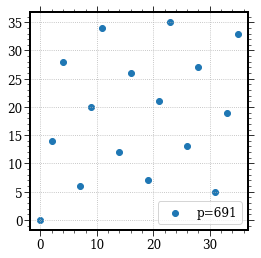

In [5]:
# find a good prime for hashing purpose

NB = 36
xy = np.empty((2, 16), dtype=np.uint8)

for p in range(1000):
    if not isprime(p): continue
    for k in range(16):
        xy[:, k] = divmod(k*p%NB**2, NB)

    is_good = True
    for i in range(2):
        if xy[i].max() < NB-1: is_good = False
        if np.unique(xy[i]).size < 16: is_good = False
    if not is_good: continue

    fig, ax = plt.subplots()
    ax.scatter(*xy, label=f'{p=}')
    ax.legend()

    ax.set_aspect('equal', adjustable='box')
    format_axis(ax)
    plt.show()

# Configurations and Shell scripts

In [6]:
import re
from pyimcom.config import Config, Settings as Stn

In [7]:
# make benchmark configurations for Cholesky kernel

kernel = 'Chol'
suite = 'benchmark'

if False:  # 6/18/2024
    for band in BANDS:
        cfg = Config(INCONFIG / f'config_prod-{band[0]}.json')
        cfg.extrainput = [None, 'labnoise', 'gsstar14', 'gsext14,seed=100', '1fnoise9', 'whitenoise10']
        cfg.outstem = str(SCRATCH / f'paper4_{band}_{kernel}'
                          / f'{band}_{kernel}_{suite}' / f'{band}_{kernel}_{suite}')
        cfg.tempfile = f'/tmp/pyimcomrun_{band[0]}{kernel[0]}{suite[0]}'
        cfg.to_file(OUTCONFIG / f'{band}_{kernel}_{suite}.json')

In [8]:
# make benchmark configurations for iterative kernel

kernel = 'Iter'
suite = 'benchmark'

if False:  # 6/18/2024
    for band in BANDS:
        cfg = Config(OUTCONFIG / f'{band}_Chol_benchmark.json')
        cfg.linear_algebra = 'Iterative'
        cfg.iter_rtol = 1.5e-3
        cfg.iter_max = 30

        cfg.fade_kernel = 0
        cfg.instamp_pad = 0.60 * Stn.arcsec
        cfg.kappaC_arr *= 0.0

        cfg.outstem = str(SCRATCH / f'paper4_{band}_{kernel}'
                          / f'{band}_{kernel}_{suite}' / f'{band}_{kernel}_{suite}')
        cfg.tempfile = f'/tmp/pyimcomrun_{band[0]}{kernel[0]}{suite[0]}'
        cfg.to_file(OUTCONFIG / f'{band}_{kernel}_{suite}.json')

In [9]:
# make variation configurations for both kernels

if False:  # 6/18/2024
    for band in BANDS:
        for kernel in KERNELS:
            for suite in SUITES['Common'] + SUITES[kernel]:
                cfg = Config(OUTCONFIG / f'{band}_{kernel}_benchmark.json')
                if suite == 'benchmark': continue
                recognized = True

                if suite.startswith('airy'):
                    cfg.outpsf = suite.upper()
                elif suite.startswith('gauss'):
                    m = re.match('gauss_([0-9.]+)x', suite)
                    cfg.sigmatarget *= float(m.group(1))

                elif suite.startswith('psf'):
                    if suite == 'psfcirc':
                        cfg.psf_circ = True
                    elif suite == 'psfnorm':
                        cfg.psf_norm = True
                    else:
                        recognized = False
                elif suite.endswith('pen'):
                    if suite == 'amppen':
                        cfg.amp_penalty = (1.0, 1.5)
                    elif suite == 'flatpen':
                        cfg.flat_penalty = 1e-7
                    else:
                        recognized = False

                elif suite.startswith('kappac'):  # Cholesky kernel only
                    m = re.match('kappac_([0-9]+)x', suite)
                    cfg.kappaC_arr *= int(m.group(1))
                elif suite.startswith('rtol'):  # iterative kernel only
                    m = re.match('rtol=([0-9.e-]+)', suite)
                    cfg.iter_rtol = float(m.group(1))
                    if cfg.iter_rtol < 1e-3:
                        cfg.iter_max = 40
                elif suite.startswith('inpad'):
                    m = re.match('inpad=([0-9.]+)', suite)
                    cfg.instamp_pad = float(m.group(1)) * Stn.arcsec

                else:
                    recognized = False

                if recognized:
                    # print(f' > {band}_{kernel}_{suite}.json')
                    cfg.outstem = str(SCRATCH / f'paper4_{band}_{kernel}'
                                      / f'{band}_{kernel}_{suite}' / f'{band}_{kernel}_{suite}')
                    cfg.tempfile = f'/tmp/pyimcomrun_{band[0]}{kernel[0]}{suite[0]}'
                    cfg.to_file(OUTCONFIG / f'{band}_{kernel}_{suite}.json')
                else:
                    print(' > Unrecognized suite:', kernel, suite)

In [10]:
# write Shell scripts

if False:  # 6/18/2024
    for band in BANDS:
        for kernel in KERNELS:
            for suite in SUITES['Common'] + SUITES[kernel]:
            # for suite in ['benchmark', 'airyobsc', 'airyunobsc']:  # 6/22/2024
                if (PROJECT / 'paper4_outputs' / f'{band}_{kernel}_{suite}.out').exists():
                    continue
                print(f' > {band}_{kernel}_{suite}.sh')

                if False:
                    lines = ['#!/bin/bash\n', '#SBATCH --account=PCON0003\n']
                    lines.append(f'#SBATCH --job-name={band}_{kernel}\n')
                    lines.append('#SBATCH --time=7-00:00:00\n')
                    lines.append(f'#SBATCH --ntasks={16 + (kernel == "Chol") * 4}\n')
                    lines.append(f'#SBATCH --output={str(PROJECT)}/paper4_outputs/{band}_{kernel}_{suite}.out\n')
                    lines.extend(['\n', 'cd ..\n'])
                    lines.append(f'perl multiblock_paper4.pl {band} {kernel} {suite} 36 0 16 1\n')

                    with open(SCRIPTS / f'{band}_{kernel}_{suite}.sh', 'w') as f:
                        f.writelines(lines)

# Dealing with target output PSFs

In [11]:
from pyimcom.psfutil import PSFGrp
PSFGrp.setup(npixpsf=48, oversamp=8, dtheta=1.0850694444444445e-05)
from pyimcom_croutines import gridD5512C
from scipy.optimize import fsolve

In [12]:
# from pyimcom.routine import iD5512C_getw does not work

def iD5512C_getw(w: np.array, fh: float) -> None:
    fh2 = fh * fh
    e_ =  (((+1.651881673372979740E-05*fh2 - 3.145538007199505447E-04)*fh2 +
          1.793518183780194427E-03)*fh2 - 2.904014557029917318E-03)*fh2 + 6.187591260980151433E-04
    o_ = ((((-3.486978652054735998E-06*fh2 + 6.753750285320532433E-05)*fh2 -
          3.871378836550175566E-04)*fh2 + 6.279918076641771273E-04)*fh2 - 1.338434614116611838E-04)*fh
    w[0] = e_ + o_
    w[9] = e_ - o_
    e_ =  (((-1.146756217210629335E-04*fh2 + 2.883845374976550142E-03)*fh2 -
          1.857047531896089884E-02)*fh2 + 3.147734488597204311E-02)*fh2 - 6.753293626461192439E-03
    o_ = ((((+3.121412120355294799E-05*fh2 - 8.040343683015897672E-04)*fh2 +
          5.209574765466357636E-03)*fh2 - 8.847326408846412429E-03)*fh2 + 1.898674086370833597E-03)*fh
    w[1] = e_ + o_
    w[8] = e_ - o_
    e_ =  (((+3.256838096371517067E-04*fh2 - 9.702063770653997568E-03)*fh2 +
          8.678848026470635524E-02)*fh2 - 1.659182651092198924E-01)*fh2 + 3.620560878249733799E-02
    o_ = ((((-1.243658986204533102E-04*fh2 + 3.804930695189636097E-03)*fh2 -
          3.434861846914529643E-02)*fh2 + 6.581033749134083954E-02)*fh2 - 1.436476114189205733E-02)*fh
    w[2] = e_ + o_
    w[7] = e_ - o_
    e_ =  (((-4.541830837949564726E-04*fh2 + 1.494862093737218955E-02)*fh2 -
          1.668775957435094937E-01)*fh2 + 5.879306056792649171E-01)*fh2 - 1.367845996704077915E-01
    o_ = ((((+2.894406669584551734E-04*fh2 - 9.794291009695265532E-03)*fh2 +
          1.104231510875857830E-01)*fh2 - 3.906954914039130755E-01)*fh2 + 9.092432925988773451E-02)*fh
    w[3] = e_ + o_
    w[6] = e_ - o_
    e_ =  (((+2.266560930061513573E-04*fh2 - 7.815848920941316502E-03)*fh2 +
          9.686607348538181506E-02)*fh2 - 4.505856722239036105E-01)*fh2 + 6.067135256905490381E-01
    o_ = ((((-4.336085507644610966E-04*fh2 + 1.537862263741893339E-02)*fh2 -
          1.925091434770601628E-01)*fh2 + 8.993141455798455697E-01)*fh2 - 1.213035309579723942E+00)*fh
    w[4] = e_ + o_
    w[5] = e_ - o_

In [13]:
def psf_get_fwhm(psf, visualize: bool = True):
    # from PSFGrp._sample_psf
    ny, nx = np.shape(psf)[-2:]
    xctr = (nx-1) / 2.0
    yctr = (ny-1) / 2.0

    # extract PSF on the x-axis
    out_arr = np.zeros((1, PSFGrp.nsamp))
    gridD5512C(np.pad(psf, 6), PSFGrp.yxo[None, 1, 0, :]+xctr+6,
               PSFGrp.yxo[None, 0, PSFGrp.nc:PSFGrp.nc+1, 0]+yctr+6, out_arr)
    hm = out_arr[0, PSFGrp.nc]/2  # half maximum

    if visualize:
        fig, ax = plt.subplots()

        ax.plot(out_arr[0, PSFGrp.nc:PSFGrp.nc+25], 'rx')
        ax.axhline(hm, c='b', ls='--')

        format_axis(ax)
        plt.show()

    idx = np.searchsorted(-out_arr[0, PSFGrp.nc:], -hm)
    idx += PSFGrp.nc

    w = np.empty((10,))
    def func(fh):
        iD5512C_getw(w, fh)
        return w @ out_arr[0, idx-5:idx+5] - hm

    fh = fsolve(func, 0)[0]
    idx -= PSFGrp.nc
    return (idx-.5+fh)*2

In [14]:
def explore_outpsfs(band, OPTSMOOTH: dict = None):
    cfg = Config(OUTCONFIG / f'{band}_Chol_benchmark.json')
    oversamp = cfg.inpsf_oversamp  # shortcut
    print('FWHMs of target output PSFs in', band)

    # default Gaussian
    psf_dg = PSFGrp._get_outpsf(cfg.outpsf, cfg.sigmatarget, cfg.use_filter)
    fwhm_dg = psf_get_fwhm(psf_dg, visualize=False) / oversamp
    print('default Gaussian:', fwhm_dg, '(measured),',
          cfg.sigmatarget * np.sqrt(8*np.log(2)), '(exact),',
          np.sum(np.square(psf_dg)), '(L2-norm)'); del psf_dg

    # narrow Gaussian
    psf_ng = PSFGrp._get_outpsf(cfg.outpsf, cfg.sigmatarget*0.8, cfg.use_filter)
    fwhm_ng = psf_get_fwhm(psf_ng, visualize=False) / oversamp; del psf_ng
    print('narrow Gaussian:', fwhm_ng, '(measured),',
          cfg.sigmatarget*0.8 * np.sqrt(8*np.log(2)), '(exact)')

    def func(extrasmooth, outpsf):
        psf_ao = PSFGrp._get_outpsf(outpsf, extrasmooth, cfg.use_filter)
        fwhm_ao = psf_get_fwhm(psf_ao, visualize=False) / oversamp
        return fwhm_ao - fwhm_dg

    # obscured Airy disk
    psf_ao0 = PSFGrp._get_outpsf('AIRYOBSC', 0.0, cfg.use_filter)
    fwhm_ao0 = psf_get_fwhm(psf_ao0, visualize=False) / oversamp; del psf_ao0
    fwhm_ao = fsolve(func, (fwhm_dg**2 - fwhm_ao0**2) ** 0.5, ('AIRYOBSC',))[0]
    print('obscured Airy:', fwhm_ao0, '(no smoothing),', fwhm_ao, '(optimal smoothing)')
    if OPTSMOOTH is not None: OPTSMOOTH[(band, 'AIRYOBSC')] = fwhm_ao

    # unobscured Airy disk
    psf_au0 = PSFGrp._get_outpsf('AIRYUNOBSC', 0.0, cfg.use_filter)
    fwhm_au0 = psf_get_fwhm(psf_au0, visualize=False) / oversamp; del psf_au0
    fwhm_au = fsolve(func, (fwhm_dg**2 - fwhm_ao0**2) ** 0.5, ('AIRYUNOBSC',))[0]
    print('unobscured Airy:', fwhm_au0, '(no smoothing),', fwhm_au, '(optimal smoothing)')
    if OPTSMOOTH is not None: OPTSMOOTH[(band, 'AIRYUNOBSC')] = fwhm_au

In [15]:
OPTSMOOTH = {}

for band in BANDS:
    explore_outpsfs(band, OPTSMOOTH)
    if band != BANDS[-1]: print()

FWHMs of target output PSFs in Y106
default Gaussian: 2.0000000002319176 (measured), 2.0 (exact), 0.0017237156261925891 (L2-norm)
narrow Gaussian: 1.6000000013111657 (measured), 1.6 (exact)
obscured Airy: 0.8157640120306425 (no smoothing), 0.7263047996919942 (optimal smoothing)
unobscured Airy: 0.858181309060821 (no smoothing), 0.7643670850999693 (optimal smoothing)

FWHMs of target output PSFs in J129
default Gaussian: 2.1000000004727504 (measured), 2.1 (exact), 0.0015634608854354563 (L2-norm)
narrow Gaussian: 1.6800000007342024 (measured), 1.6800000000000002 (exact)
obscured Airy: 0.9986747354698722 (no smoothing), 0.7456645509920108 (optimal smoothing)
unobscured Airy: 1.0506028624947281 (no smoothing), 0.7787898084859678 (optimal smoothing)

FWHMs of target output PSFs in H158
default Gaussian: 2.2000000004812152 (measured), 2.2 (exact), 0.001424558368754206 (L2-norm)
narrow Gaussian: 1.7600000003307918 (measured), 1.7600000000000002 (exact)
obscured Airy: 1.2226673874828662 (no sm

J129 GAUSSIAN


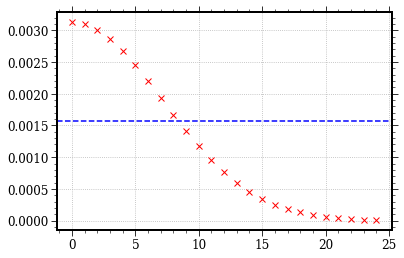

J129 AIRYOBSC


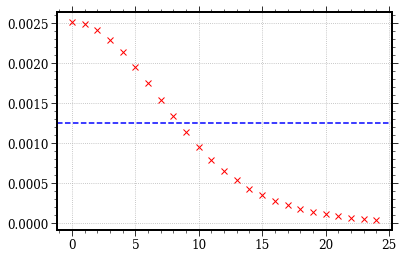

J129 AIRYUNOBSC


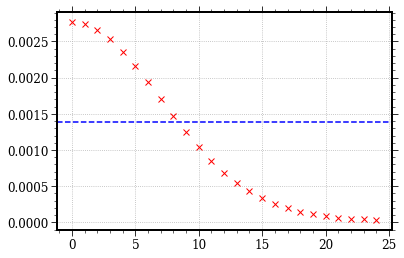

In [16]:
for band in BANDS[1:2]:
    for outpsf in ['GAUSSIAN', 'AIRYOBSC', 'AIRYUNOBSC']:
        cfg = Config(OUTCONFIG / f'{band}_Chol_benchmark.json')
        sigmatarget = OPTSMOOTH.get((band, outpsf), cfg.sigmatarget)
        psf = PSFGrp._get_outpsf(outpsf, sigmatarget, cfg.use_filter)
        print(band, outpsf)
        psf_get_fwhm(psf, visualize=True)

In [17]:
# update sigmatarget for outpsf variations

if False:  # 6/18/2024
    for band in BANDS:
        for kernel in KERNELS:
            for suite in ['airyobsc', 'airyunobsc']:
                cfg = Config(OUTCONFIG / f'{band}_{kernel}_{suite}.json')
                cfg.sigmatarget = OPTSMOOTH[(band, suite.upper())]
                cfg.to_file(OUTCONFIG / f'{band}_{kernel}_{suite}.json')